# Earthquake_prac
> practice

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [98]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [99]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1970"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/1970,-29.4000,-177.1690,5.6,1970
1,01/04/1970,24.1850,102.5430,7.1,1970
2,01/05/1970,23.9840,102.7320,5.9,1970
3,01/06/1970,-9.5830,151.4930,6.3,1970
4,01/07/1970,15.7850,-59.8080,6.0,1970
...,...,...,...,...,...
21951,12/28/2016,38.3917,-118.8941,5.6,2016
21952,12/28/2016,38.3777,-118.8957,5.5,2016
21953,12/28/2016,36.9179,140.4262,5.9,2016
21954,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [100]:
f = _df.loc[:,"Magnitude"]

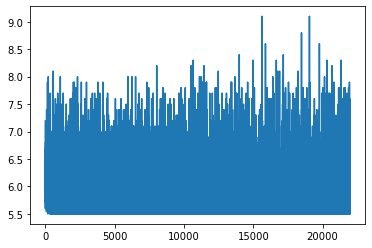

In [101]:
plt.plot(f,'-')

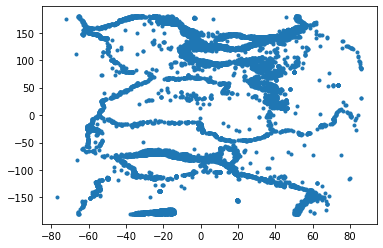

In [102]:
plt.plot( _df.Latitude,_df.Longitude,'.')

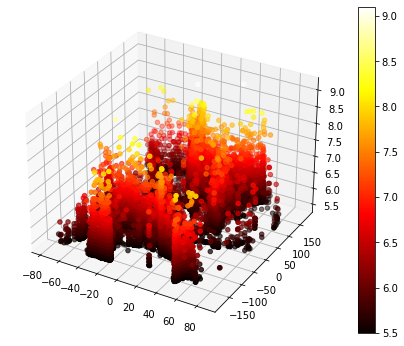

In [103]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [104]:
_dfgraph = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1970"').reset_index().iloc[:,1:].reset_index()

/tmp/ipykernel_164507/2573661339.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(_dfgraph.Year)


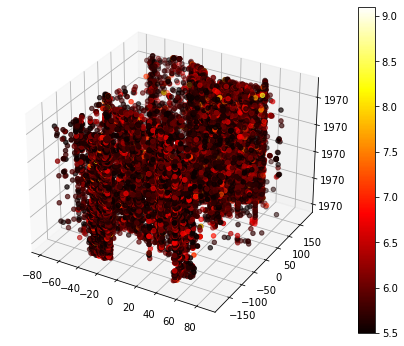

In [105]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zticklabels(_dfgraph.Year)
img = ax.scatter(_dfgraph.Latitude, _dfgraph.Longitude, _dfgraph.index,c= _dfgraph.Magnitude, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [106]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1970)]

In [107]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [108]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(1970,2016))).add_to(m)
m

In [68]:
from mpl_toolkits.basemap import Basemap

ImportError: cannot import name 'dedent' from 'matplotlib.cbook' (/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py)

In [433]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

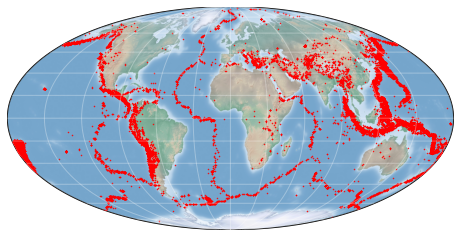

In [434]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

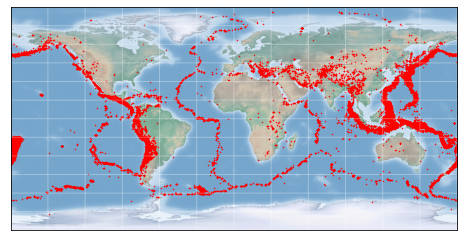

In [435]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [109]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) > 90: 
        return 10000  
    elif abs( _df.Longitude[j] - _df.Longitude[i] ) > 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [110]:
def weight(i,j,theta=150,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

6시간 정도 걸림

In [111]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [112]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 1.   , ..., 0.965, 0.97 , 0.963],
       [0.   , 1.   , 1.   , ..., 0.965, 0.971, 0.963],
       ...,
       [0.   , 0.965, 0.965, ..., 1.   , 0.944, 1.   ],
       [0.   , 0.97 , 0.971, ..., 0.944, 1.   , 0.942],
       [0.   , 0.963, 0.963, ..., 1.   , 0.942, 1.   ]])

(array([2.68110980e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.82400000e+03, 3.73300600e+06,
        4.43704520e+07, 1.65849674e+08]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

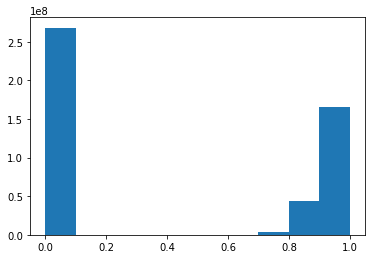

In [113]:
plt.hist(W.reshape(-1))

그래프

nx.draw(nx.Graph(W))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [114]:
D = np.diag(W.sum(axis=1))

In [115]:
D

array([[ 4542.79001504,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        , 12781.97082921,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        , 12785.85141056, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        12149.2850269 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        , 12730.94003662,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        , 12118.80476293]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [116]:
L = D - W

In [117]:
L

array([[ 4.54179002e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.27809708e+04, -9.99998308e-01, ...,
        -9.65127805e-01, -9.70165078e-01, -9.63242966e-01],
       [ 0.00000000e+00, -9.99998308e-01,  1.27848514e+04, ...,
        -9.65323533e-01, -9.70582756e-01, -9.63442151e-01],
       ...,
       [ 0.00000000e+00, -9.65127805e-01, -9.65323533e-01, ...,
         1.21482850e+04, -9.44181666e-01, -9.99973372e-01],
       [ 0.00000000e+00, -9.70165078e-01, -9.70582756e-01, ...,
        -9.44181666e-01,  1.27299400e+04, -9.42335310e-01],
       [ 0.00000000e+00, -9.63242966e-01, -9.63442151e-01, ...,
        -9.99973372e-01, -9.42335310e-01,  1.21178048e+04]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [118]:
λ, Ψ = np.linalg.eig(L)

In [119]:
Λ = np.diag(λ)

---

푸리에

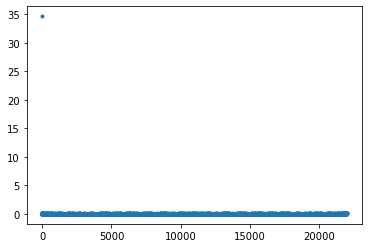

In [149]:
fbar = np.abs(np.fft.fft(f**2))/len(f)
plt.plot(fbar,'.')

In [150]:
fbar[0] 

34.66625036891965

In [151]:
len(f)/2

10978.0

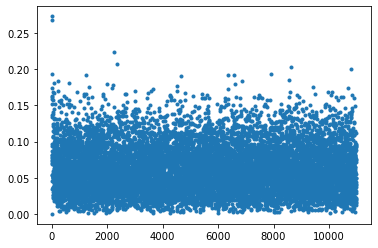

In [152]:
fbar2=np.zeros(10978)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:10978] = 2*fbar[1:10978]
plt.plot(fbar2,'.')

In [153]:
fbar2[:10]

array([0.        , 0.1611141 , 0.27334459, 0.17475909, 0.26822364,
       0.19282027, 0.15899214, 0.0784173 , 0.07097817, 0.06848595])

---

##### 8. p
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = (sum(comp1^2),sum(comp2^2),…,sum(comp8000^2))$
- $p = p/sum(p)$
    - 0.2 0.1  ...
- —> 5개의 최상의 컴포넌트만 골랐더니 70%

In [125]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [126]:
def p(i):
    return sum(comp(i)**2)

In [127]:
p(0)

757261.9896308627

In [ ]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [ ]:
varprop = array_1/array_1.sum()

In [ ]:
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [ ]:
_indexlst

In [ ]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

In [ ]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

In [ ]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [ ]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [ ]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [ ]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [ ]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [ ]:
_df["comp1"] = comp1

In [ ]:
_df["comp2"] = comp2

In [ ]:
_df["comp3"] = comp3

In [ ]:
_df["comp4"] = comp4

In [ ]:
_df["comp5"] = comp5

In [ ]:
#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
#collapse
__lst1=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
#collapse
__lst2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
#collapse
__lst3=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
#collapse
__lst4=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
#collapse
__lst5=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,9]].\
to_numpy().tolist() for i in range(2016-1970)]

In [ ]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(1970,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [ ]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=20,index=list(range(1970,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [ ]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=20,index=list(range(1970,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [ ]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=20,index=list(range(1970,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [ ]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=20,index=list(range(1970,2016))).add_to(_m)
_m

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

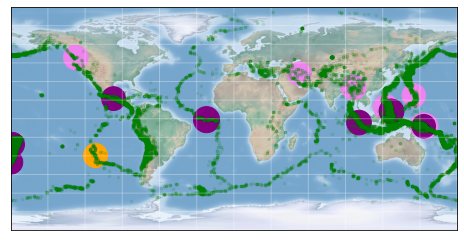

In [472]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)

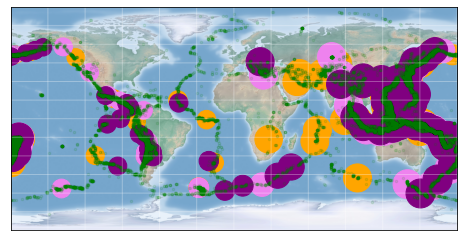

In [476]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0:100]], y[np.argsort(λ)[0:100]], color='orange', s=abs(f_hat[np.argsort(λ)[0:100]])*scale)
m.scatter(x[np.argsort(λ)[101:200]], y[np.argsort(λ)[101:200]], color='violet', s=abs(f_hat[np.argsort(λ)[101:200]])*scale)
m.scatter(x[np.argsort(λ)[201:300]], y[np.argsort(λ)[201:300]], color='purple', s=abs(f_hat[np.argsort(λ)[201:300]])*scale)
draw_map(m)

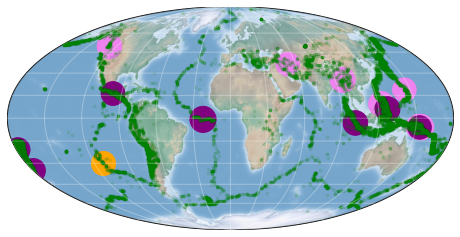

In [474]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)